In [1]:
import numpy as np
import sympy as sp
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
import time as Time
from skimage.metrics import structural_similarity

## Nombre: Joaquín Castillo Tapia
### rol : 201773520-1

# Tarea 3:Interpolación Bicúbica

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 24 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).


## Introducción

En la siguiente tarea estudiaremos un método de interpolación denominado **Interpolación Bicúbica**, utilizada frecuentemente sobre imágenes. Aplicaremos el método para aumentar la resolución de una imagen intentando preservar las propiedades de la versión original.

## Contexto

Supongamos que usted conoce $f$ y las derivadas $f_x$, $f_y$ y $f_{xy}$ dentro de las coordenadas $(0,0),(0,1),(1,0)$ y $(1,1)$ de un cuadrado unitario. La superficie que interpola estos 4 puntos es:

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$

Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$ y para esto se genera un total de $16$ ecuaciones utilizando los valores conocidos de $f$,$f_x$,$f_y$ y $f_{xy}$. Por ejemplo, las primeras $4$ ecuaciones son:

$$
\begin{aligned}
f(0,0)&=p(0,0)=a_{00},\\
f(1,0)&=p(1,0)=a_{00}+a_{10}+a_{20}+a_{30},\\
f(0,1)&=p(0,1)=a_{00}+a_{01}+a_{02}+a_{03},\\
f(1,1)&=p(1,1)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=0}^{3}a_{ij}.
\end{aligned}
$$

Para las $12$ ecuaciones restantes se debe utilizar:

$$
\begin{aligned}
f_{x}(x,y)&=p_{x}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=0}^{3}a_{ij}ix^{i-1}y^{j},\\
f_{y}(x,y)&=p_{y}(x,y)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=1}^{3}a_{ij}x^{i}jy^{j-1},\\
f_{xy}(x,y)&=p_{xy}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=1}^{3}a_{ij}ix^{i-1}jy^{j-1}.
\end{aligned}
$$


Una vez planteadas las ecuaciones, los coeficientes se pueden obtener al resolver el problema $A\alpha=x$, donde $\alpha=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T$ y ${\displaystyle x=\left[{\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&f_{x}(0,0)&f_{x}(1,0)&f_{x}(0,1)&f_{x}(1,1)&f_{y}(0,0)&f_{y}(1,0)&f_{y}(0,1)&f_{y}(1,1)&f_{xy}(0,0)&f_{xy}(1,0)&f_{xy}(0,1)&f_{xy}(1,1)\end{smallmatrix}}\right]^{T}}$.


En un contexto más aplicado, podemos hacer uso de la interpolación bicúbica para aumentar la resolución de una imagen. Supongamos que tenemos la siguiente imagen de tamaño $5 \times 5$:

<img src="img1.png" width="20%"/>

Podemos ir tomando segmentos de la imagen de tamaño $2 \times 2$ de la siguiente forma:

<img src="img2.png" width="50%"/>

Por cada segmento podemos generar una superficie interpoladora mediante el algoritmo de interpolación cubica. Para el ejemplo anterior estariamos generando $16$ superficies interpoladoras distintas. La idea es hacer uso de estas superficies para estimar los valores de los pixeles correspondienets a una imagen más grande. Por ejemplo, la imagen $5 \times 5$ la podemos convertir a una imagen de $9 \times 9$ agregando un pixel entre cada par de pixeles originales además de uno en el centro para que no quede un hueco.

<img src="img3.png" width="50%"/>

Aca los pixeles verdes son los mismos que la imagen original y los azules son obtenidos de evaluar cada superficie interpoladora. Notar que existen pixeles azules que se pueden obtener a partir de dos superficies interpoladoras distintas, en esos casos se puede promediar el valor de los pixeles o simplemente dejar uno de los dos. 

Para trabajar con la interpolación bicubica necesitamos conocer los valores de $f_x$, $f_y$ y $f_{xy}$. En el caso de las imagenes solo tenemos acceso al valor de cada pixel por lo que deberemos estimar cual es el valor de estos. Para estimar $f_x$ haremos lo siguiente:

Para estimar el valor de $f_x$ en cada pixel haremos una interpolación con los algoritmos conocidos, usando tres pixels en dirección de las filas, luego derivaremos el polinomio obtenido y finalmente evaluaremos en la posición de interes. La misma idea aplica para $f_y$ solo que ahora interpolaremos en dirección de las columnas.

<img src="img5.png" width="60%"/>

Por ejemplo si queremos obtener el valor de $f_x$ en la posición $(0,0)$ (imagen de la izquierda) entonces haremos una interpolación de Lagrange utilizando los pixeles $(0,0),(0,1)$ y $(0,2)$. Derivaremos el polinomio interpolador y evaluaremos en $(0,0)$. Por otro lado si queremos obtener el valor de $f_y$ en la posición $(0,0)$ (imagen de la derecha) entonces interpolaremos los pixeles $(0,0),(1,0)$ y $(2,0)$. Luego derivaremos el polinomio interpolador y evaluaremos en $(0,0)$.

Para obtener $f_{xy}$ seguiremos la idea anterior. Solo que esta vez se utilizaran los valores de $f_y$ y se interpolaran estos en dirección de las filas.

# Preguntas

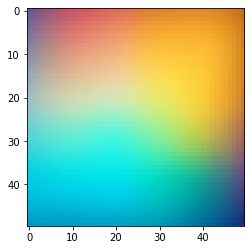

In [2]:
#Codigo para abrir y visualizar imágenes
img = Image.open('imagenes_prueba/gradient.png')
array=np.array(img)
imgplot = plt.imshow(array)
plt.show()

## 1. Interpolación bicubica

### 1.1  Obtener derivadas (30 puntos)

Implemente la función `derivativeValues` que reciba como input un arreglo con valores, el método de interpolación y si es que se considera el uso de  los puntos de chebyshev . La función debe retornar un arreglo de igual dimensión con los valores de las derivadas de los puntos obtenidas

Los métodos de interpolación serán representados por los siguientes valores

* Interpolación de lagrange: `'lagrange'`
* Diferencias divididas de Newton: `'newton'`
* Spline cubica: `'spline3'`


In [3]:
# Se utilizan las siguientes funciones vistas en clases:
# github.com/tclaudioe/Scientific-Computing/blob/master/SC1/07_Polynomial_Interpolation_1D.ipynb

def Chebyshev_points(xmin,xmax,n):
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    return (xmin+xmax)/2 + (xmax-xmin)*x/2

def Divided_Differences(x, y):
    dd = np.array([y])
    for i in range(len(x)-1):
        ddi = []
        for a in range(len(x)-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((len(x)-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
    return np.array(dd)
    
def Newton(x, y, show=False):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(len(x))])
        xS = sp.Symbol('x')
        N = np.dot(dd[:,0],np.append([1],[np.prod(xS-x[:i]) for i in range(1,len(dd))]))
        print('Interpolation Function: ');
        print(N)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Newton',
         'P':dd[:,0],
         'x':x,
         'y':y}
    return D

In [4]:
def derivativeValues(values, method, cheb):
    """
    Parameters
    ----------
    values:    (int array) points values
    method:    (string)    interpolation method
    cheb:    (boolean)    if chebyshev points are used

    Returns
    -------
    d:    (float array) derivative value of interpolated points

    """
    n = values.size
    d = np.zeros(n)
    
    if cheb: 
        x = Chebyshev_points(1,n,n)
        x = np.sort(x)
    else:
        x = np.array(range(0, n ))
    
    if method == 'lagrange':
        P = interpolate.lagrange(x, values)
        derivada = np.poly1d.deriv(P)
        for i in range(n):
            d[i] = derivada(x[i])
        
    elif method == 'newton':
        D = Newton(x, values)
        P_coef = D['P']
        for i in range(n):
            derivada = P_coef[1]
            # F(x)= (x - x_1)
            F = x[i] - x[0] 
            # F'(x)= 1
            Fp = 1 
            for j in range(1,n-1):
                G = x[i] - x[j]
                aux = P_coef[j+1] * (Fp*G + F)
                derivada = derivada + aux 
                Hp = Fp
                H = F
                Fp = (Hp*G) 
                Fp = Fp + H
                F = H*G
                
            d[i] = derivada
            
    elif method == 'spline3':
        P = interpolate.CubicSpline(x, values)
        derivada = P.derivative()
        for i in range(n):
            d[i] = derivada(x[i])
    
    return d


### 1.2 Interpolación de imagen (50 puntos)
Implemente la función `bicubicInterpolation` que reciba como input la matriz de la imagen y cuantos píxeles extra se quiere agregar entre los píxeles originales y el algoritmo de interpolación a utilizar. La función debe retornar la matriz con la imagen de dimensión nueva. Considere que se debe aplicar el método de interpolación en cada canal RGB por separado.

In [5]:
# Se definen las siguientes funciones para modularizar el código

## Función que crea la matriz de todos los coeficientes necesarios para construir los polinomios P.
def matriz_X(A,F,Fx,Fy,Fxy,n):
    I = []
    for i in range(n-1):
        J = []
        for j in range(n-1):
            
            b = np.zeros(16)
            
            b[0] = F[i][j]
            b[1] = F[i+1][j]
            b[2] = F[i][j+1]
            b[3] = F[i+1][j+1]
            
            b[4] = Fx[i][j]
            b[5] = Fx[i+1][j]
            b[6] = Fx[i][j+1]
            b[7] = Fx[i+1][j+1]
            
            b[8] = Fy[i][j]
            b[9] = Fy[i+1][j]
            b[10] = Fy[i][j+1]
            b[11] = Fy[i+1][j+1]
            
            b[12] = Fxy[i][j]
            b[13] = Fxy[i+1][j]
            b[14] = Fxy[i][j+1]
            b[15] = Fxy[i+1][j+1]
        
            x = np.linalg.solve(A,b)
            
            J.append(x)
        I.append(J)
    
    X = np.array(I)

    return X

## Función que evalua P(x,y) a través del arreglo de coeficientes alpha de P
def evaluar_P(coef,x,y):
    coef = coef.reshape((4,4))
    coef = coef.T
    s = 0
    for i in range(4):
        for j in range(4):
            s += (coef[i][j])*(x**i)*(y**j)
    return int(s)

## Función que comprueba que un número esté entre 0 y 255
def comprobar(numero):
    if numero < 0:
        return 0
    elif numero > 255:
        return 255
    return numero


## Función que crea la nueva matriz (de cada canal RGB)
## a partir de una matriz de coeficientes y la cantidad de piexels a agregar
def newF(Z,n,cantP):
    N = np.zeros((n+cantP*(n-1),n+cantP*(n-1)))
    valores = np.linspace(0,1,cantP + 2)
    for i in range(n-1):
        for j in range(n-1):
            coef = Z[i][j]
            for k in range(valores.size):
                for l in range(valores.size):
                    N[i*(cantP+1)+k][j*(cantP+1)+l] = comprobar(evaluar_P(coef,valores[k],valores[l]))
    return N
            

In [6]:
def bicubicInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    newImage:	(nxnx3 array) image array in RGB format

    """
    n = image.shape[0]
    aux = image.reshape((n*n,3))
    auxT = aux.T
    
    r = auxT[0].reshape((n,n))
    g = auxT[1].reshape((n,n))
    b = auxT[2].reshape((n,n))

    rx = np.empty((n,n))
    ry = np.empty((n,n))
    rxy = np.empty((n,n))

    gx = np.empty((n,n))
    gy = np.empty((n,n))
    gxy = np.empty((n,n))

    bx = np.empty((n,n))
    by = np.empty((n,n))
    bxy = np.empty((n,n))
    
    for j in range(n):
        for i in range(1,n-1):
            # ROJO
            values_r1 = np.array([r[j][i-1],r[j][i],r[j][i+1]],dtype='int')
            pr1,pr2,pr3 = derivativeValues(values_r1,method,cheb)

            values_r2 = np.array([r[i-1][j],r[i][j],r[i+1][j]],dtype='int')
            vr1,vr2,vr3 = derivativeValues(values_r2,method,cheb)

            # GREEN
            values_g1 = np.array([g[j][i-1],g[j][i],g[j][i+1]],dtype='int')
            pg1,pg2,pg3 = derivativeValues(values_g1,method,cheb)

            values_g2 = np.array([g[i-1][j],g[i][j],g[i+1][j]],dtype='int')
            vg1,vg2,vg3 = derivativeValues(values_g2,method,cheb)

            # BLUE
            values_b1 = np.array([b[j][i-1],b[j][i],b[j][i+1]],dtype='int')
            pb1,pb2,pb3 = derivativeValues(values_b1,method,cheb)

            values_b2 = np.array([b[i-1][j],b[i][j],b[i+1][j]],dtype='int')
            vb1,vb2,vb3 = derivativeValues(values_b2,method,cheb)
            if i == 1:
                # RED
                rx[j][0] = pr1
                rx[j][1] = pr2

                ry[0][j] = vr1
                ry[1][j] = vr2

                # GREEN
                gx[j][0] = pg1
                gx[j][1] = pg2

                gy[0][j] = vg1
                gy[1][j] = vg2

                # BLUE
                bx[j][0] = pb1
                bx[j][1] = pb2

                by[0][j] = vb1
                by[1][j] = vb2

            elif i == n-2:
                # RED
                rx[j][-2] = pr2
                rx[j][-1] = pr3

                ry[-2][j] = vr2
                ry[-1][j] = vr3

                # GREEN
                gx[j][-2] = pg2
                gx[j][-1] = pg3

                gy[-2][j] = vg2
                gy[-1][j] = vg3

                # BLUE
                bx[j][-2] = pb2
                bx[j][-1] = pb3

                by[-2][j] = vb2
                by[-1][j] = vb3

            else:
                # RED
                rx[j][i] = pr2

                ry[i][j] = vr2

                # GREEN
                gx[j][i] = pg2

                gy[i][j] = vg2

                # BLUE
                bx[j][i] = pb2

                by[i][j] = vb2


    for j in range(n):
        for i in range(1,n-1):
            # RED
            values_r = np.array([ry[j][i-1],ry[j][i],ry[j][i+1]],dtype='int')
            zr1,zr2,zr3 = derivativeValues(values_r,method,cheb)

            # GREEN
            values_g = np.array([gy[j][i-1],gy[j][i],gy[j][i+1]],dtype='int')
            zg1,zg2,zg3 = derivativeValues(values_g,method,cheb)

            # BLUE
            values_b = np.array([by[j][i-1],by[j][i],by[j][i+1]],dtype='int')
            zb1,zb2,zb3 = derivativeValues(values_b,method,cheb)

            if i == 1:
                # RED 
                rxy[j][0] = zr1
                rxy[j][1] = zr2

                # GREEN 
                gxy[j][0] = zg1
                gxy[j][1] = zg2

                # BLUE 
                bxy[j][0] = zb1
                bxy[j][1] = zb2

            elif i == n-2:
                # RED
                rxy[j][-2] = zr2
                rxy[j][-1] = zr3

                # GREEN
                gxy[j][-2] = zg2
                gxy[j][-1] = zg3

                # BLUE
                bxy[j][-2] = zb2
                bxy[j][-1] = zb3

            else:
                # RED
                rxy[j][i] = zr2

                # GREEN
                gxy[j][i] = zg2

                # BLUE
                bxy[j][i] = zb2


    A = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9]]

    A = np.array(A)

    Zr = matriz_X(A,r,rx,ry,rxy,n)
    Zg = matriz_X(A,g,gx,gy,gxy,n)
    Zb = matriz_X(A,b,bx,by,bxy,n)

    Nr = newF(Zr,n,interiorPixels)
    Ng = newF(Zg,n,interiorPixels)
    Nb = newF(Zb,n,interiorPixels)
    
    new_n = n + interiorPixels*(n-1)
    
    newR = Nr.reshape(new_n*new_n)
    newG = Ng.reshape(new_n*new_n)
    newB = Nb.reshape(new_n*new_n)
    
    newImage = [newR,newG,newB]
    newImage = np.array(newImage)
    newImage = newImage.T
    newImage = newImage.reshape((new_n,new_n,3))
    newImage = newImage.astype(int)

    return newImage

## 2. Evaluacion de algoritmos



### 2.1 Tiempo de ejecucion 
Implemente la funcion `timeInterpolation` que mida el tiempo de interpolacion de una imagen dado el algoritmo de interpolacion , en segundos.(5 puntos)

In [7]:
def timeInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    time:	(float) time in seconds

    """
    time_i = Time.time()
    newImage = bicubicInterpolation(image,interiorPixels,method,cheb)
    time_f = Time.time()
    
    time = time_f - time_i
    
    return time

***Pregunta: ¿Cual es el metodo que presenta mayor velocidad en general? (5 puntos)***

**R.-** Para obtener un mejor análisis se  evaluan las 3 imagenes de prueba, y se considera el promedio de 3 escenarios: agregar 1, 2 y 3 pixeles internos. 

### Luego de la ejecución se comentaron los bloques de código para no generar problemas en la revisón.

In [8]:
'''
img = Image.open('imagenes_prueba/gradient.png')
imagen1 = np.array(img)
img = Image.open('imagenes_prueba/cat.png').convert('RGB')
imagen2 = np.array(img)
img = Image.open('imagenes_prueba/sunset.png')
imagen3 = np.array(img)
'''

In [9]:
## Función que evalúa una imagen con los 3 métodos para distintos casos. 
## Construye un gráfico de comparación e indica en promedio cúal es el menor.
def tiempo(imagen):

    m = ["lagrange","newton","spline3"]

    te_min = float("inf")
    tc_min = float("inf")

    me = ""
    mc = ""

    y_e = []
    y_c = []
    
    for i in m:
        t_e = 0
        t_c = 0
        
        x = [1,2,3]
      
        for j in x:
            TC = timeInterpolation(imagen,j,i,True)
            t_c += TC
            y_c.append(TC)
            TE = timeInterpolation(imagen,j,i,False)
            t_e += TE
            y_e.append(TE)

        t_e = t_e/3
        t_c = t_c/3

        if t_e < te_min:
            te_min = t_e
            me = i
        if t_c < tc_min:
            tc_min = t_c
            mc = i
            
    y_eL = y_e[:3]
    y_eN = y_e[3:6]
    y_eS = y_e[6:]
    
    plt.plot(x,y_eL,"o-",label="Lagrange")
    plt.plot(x,y_eN,"o-",label="Newton")
    plt.plot(x,y_eS,"o-",label="Spline3")
    plt.grid(True)
    plt.ylabel("Tiempo")
    plt.xlabel("Pixeles Internos")
    plt.title("Puntos Equiespaciados")
    plt.legend()
    plt.show()
    print("min: ", te_min," met: "+me)
    
    
    y_cL = y_c[:3]
    y_cN = y_c[3:6]
    y_cS = y_c[6:]
    
    plt.plot(x,y_cL,"o-",label="Lagrange")
    plt.plot(x,y_cN,"o-",label="Newton")
    plt.plot(x,y_cS,"o-",label="Spline3")
    plt.grid(True)
    plt.ylabel("Tiempo")
    plt.xlabel("Pixeles Internos")
    plt.title("Puntos Chebychev")
    plt.legend()
    plt.show()
    print("min-Cheb: ", tc_min," met: "+mc)

## Imagen 1

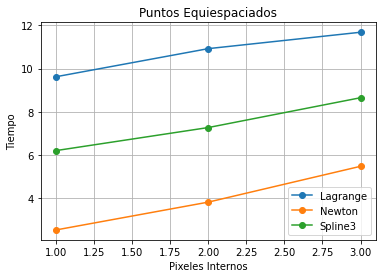

min:  3.9333879947662354  met: newton


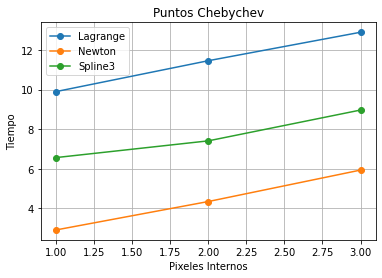

min-Cheb:  4.397366046905518  met: newton


In [10]:
'''
tiempo(imagen1)
'''

## Imagen 2

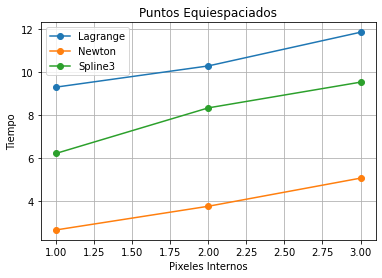

min:  3.8099414507548013  met: newton


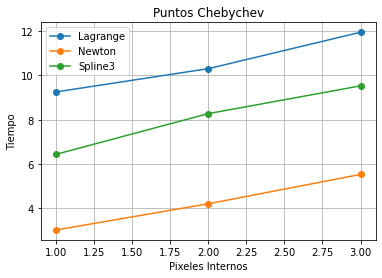

min-Cheb:  4.252854824066162  met: newton


In [11]:
'''
tiempo(imagen2)
'''

## Imagen 3

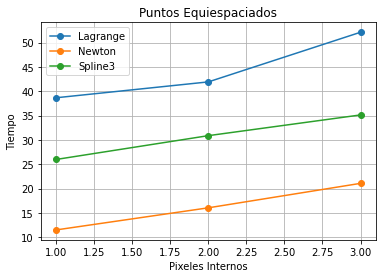

min:  16.21010700861613  met: newton


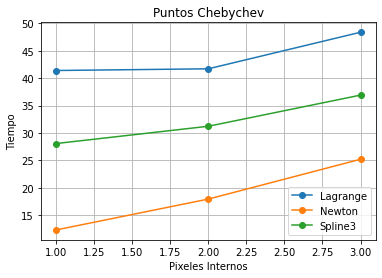

min-Cheb:  18.485653003056843  met: newton


In [12]:
'''
tiempo(imagen3)
'''

En los 6 casos evaluados el método de *Newton* fue el que obtuvo el menor tiempo.

### 2.2 Calculo de error
Implemente la funcion `errorInterpolation` la cual debe obtener el error de la imagen obtenida comparandola con una de referencia. El error debe ser calculado utilizando el indice SSIM (Structural similarity) (5 puntos)

In [13]:
def errorInterpolation(original,new):
    """
    Parameters
    ----------
    image:	(nxn array) original image array in RGB format
    new:	(nxn array) new image array in RGB format obtained from interpolation


    Returns
    -------
    error:	(float) difference between images 

    """
    n = original.shape[0]
    error = structural_similarity(original,new,multichannel=True,data_range=n)
    error = 1 - error
    return error

***Pregunta: ¿Cual metodo presenta menor error? (5 puntos)***

**R-** se utilizan las 3 imagenes de prueba, resultando en 6 casos (2 casos para cada imagen). En cada caso se ejecutaron los tres métodos, y por cada método se valua con y sin puntos de Chebychev.


### Luego de la ejecución se comentaron los bloques de código para no generar problemas en la revisón.

In [14]:
## Función que indica cuál método tiene menos error tanto para puntos Chebychev como para puntos equiespaciados.
def Errores(imagen,original,interiorPixel):
    
    lagrange = bicubicInterpolation(imagen,interiorPixel,"lagrange",False)
    e_lagrange = errorInterpolation(original, lagrange)

    newton = bicubicInterpolation(imagen,interiorPixel,"newton",False)
    e_newton = errorInterpolation(original, newton)

    spline3 = bicubicInterpolation(imagen,interiorPixel,"spline3",False)
    e_spline3 = errorInterpolation(original, spline3)

    lagrange_C = bicubicInterpolation(imagen,interiorPixel,"lagrange",True)
    e_lagrange_C = errorInterpolation(original, lagrange_C)

    newton_C = bicubicInterpolation(imagen,interiorPixel,"newton",True)
    e_newton_C = errorInterpolation(original, newton_C)

    spline3_C = bicubicInterpolation(imagen,interiorPixel,"spline3",True)
    e_spline3_C = errorInterpolation(original, spline3_C)


    E = [e_lagrange,e_newton,e_spline3]
    E_C = [e_lagrange_C,e_newton_C,e_spline3_C]

    m = ["lagrange","newton","spline3"]

    min_e = min(E)
    min_e_C = min(E_C)

    i = E.index(min_e)
    i_C = E_C.index(min_e_C)

    sm = ""
    sm_C = ""

    for i in range(3):
        if min_e == E[i]:
            sm += m[i]+" "

        if min_e_C == E_C[i]:
            sm_C += m[i]+" "

    print("min: ",min_e, "met: "+sm)
    print("min-Cheb: ",min_e_C, "met: "+sm_C)

## Imagen 1

Para la imagen 1 se considera un aumento de 1 y 4 pixeles interiores.

In [15]:
'''
img = Image.open('imagenes_prueba/gradient_1pixel.png')
original= np.array(img)

img = Image.open('imagenes_prueba/gradient.png')
imagen = np.array(img)

print("gradient (50x50) con 1 pixel intermedio")
print("---------------------------------------")
Errores(imagen,original,1)

img = Image.open('imagenes_prueba/gradient_4pixel.png')
original= np.array(img)

print("\ngradient (50x50) con 4 pixel intermedio")
print("---------------------------------------")
Errores(imagen,original,4)
'''

gradient (50x50) con 1 pixel intermedio
---------------------------------------
min:  0.008964583483500377 met: lagrange newton spline3 
min-Cheb:  0.00906725074972059 met: newton 

gradient (50x50) con 4 pixel intermedio
---------------------------------------
min:  0.011018066231233248 met: lagrange newton spline3 
min-Cheb:  0.012450118194836324 met: newton 


## Imagen 2 

Para la imagen 2 se considera un aumento de 1 y 4 pixeles interiores.

In [16]:
'''
img = Image.open('imagenes_prueba/cat_1pixel.png').convert('RGB')
original= np.array(img)

img = Image.open('imagenes_prueba/cat.png').convert('RGB')
imagen = np.array(img)

print("cat (50x50) con 1 pixel intermedio")
print("---------------------------------------")
Errores(imagen,original,1)

img = Image.open('imagenes_prueba/cat_4pixel.png').convert('RGB')
original= np.array(img)

print("\ncat (50x50) con 4 pixel intermedio")
print("---------------------------------------")
Errores(imagen,original,4)
'''

cat (50x50) con 1 pixel intermedio
---------------------------------------
min:  0.18621051858210202 met: spline3 
min-Cheb:  0.18891144551943573 met: spline3 

cat (50x50) con 4 pixel intermedio
---------------------------------------
min:  0.3104568322304043 met: lagrange newton 
min-Cheb:  0.3139672585813297 met: spline3 


## Imagen 3

Para la imagen 3 se considera un aumento de 1 y 2 pixeles interiores.

In [17]:
'''
img = Image.open('imagenes_prueba/sunset_1pixel.png')
original= np.array(img)

img = Image.open('imagenes_prueba/sunset.png')
imagen = np.array(img)

print("sunset (100x100) con 1 pixel intermedio")
print("---------------------------------------")
Errores(imagen,original,1)

img = Image.open('imagenes_prueba/sunset_2pixel.png')
original= np.array(img)

print("\nsunset (100x100) con 2 pixel intermedio")
print("---------------------------------------")
Errores(imagen,original,2)
'''

sunset (100x100) con 1 pixel intermedio
---------------------------------------
min:  0.07398961484470712 met: spline3 
min-Cheb:  0.07454650088108916 met: lagrange 

sunset (100x100) con 2 pixel intermedio
---------------------------------------
min:  0.08865940102286352 met: lagrange newton 
min-Cheb:  0.08956084786000795 met: newton 


En general no hay método que sea mejor que otro en cuanto al error, varía respecto a la imagen. Pero, en base a las imagenes usadas y los casos comparados Newton tiene 3 veces el mínimo error para puntos de Chebychev. En cunato a los puntos equiespaciados, los tres métodos aparecen 4 veces cómo mínimo.

# Consideraciones

* Solo trabajaremos con imagenes cuadradas
* En el caso que el valor interpolado de un punto sea mayor a 255 o menor a 0, este se trunca a 255 o 0 respectivamente
* Esta permitido el uso de sympy para calcular derivadas y para construir el polinomio interpolador 
* El calculo de error puede ser calculado utilizando la imagen en escala de grises [(ejemplo)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)
* La ejecución del notebook completo demora alrededor de 30 min